<a href="https://colab.research.google.com/github/aznedac2/CS231N_17_KOR_SUB/blob/master/vol_coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance arch statsmodels seaborn

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

def fetch_deribit_candles(instrument_name='BTC-PERPETUAL', resolution='1', start_timestamp=None, end_timestamp=None):
    """
    Deribit API에서 캔들 데이터 가져오기
    resolution: '1' for 1-minute, '5' for 5-minute, etc.
    """
    url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"

    params = {
        "instrument_name": instrument_name,
        "resolution": resolution,
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
    }

    resp = requests.get(url, params=params)
    data = resp.json()

    if 'result' not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame(data['result'])
    df['timestamp'] = pd.to_datetime(df['ticks'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

def get_daily_ohlc(start_date, end_date):
    """
    지정된 기간 동안 일별 OHLC 데이터 리턴
    """
    all_data = []
    current_date = start_date
    while current_date <= end_date:
        start_ts = int(current_date.timestamp() * 1000)
        end_ts = int((current_date + timedelta(days=1)).timestamp() * 1000)

        print(f"Fetching data for: {current_date.date()}")
        df = fetch_deribit_candles(start_timestamp=start_ts, end_timestamp=end_ts)

        if df is not None and not df.empty:
            # 일별 OHLC로 리샘플링
            daily = df.resample('1D').agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            })
            all_data.append(daily)

        time.sleep(0.3)  # API 요청 제한 회피
        current_date += timedelta(days=1)

    final_df = pd.concat(all_data)
    return final_df

In [ ]:
# 사용 예시
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 4, 5)
df_daily = get_daily_ohlc(start_date, end_date)
print(df_daily)

Fetching data for: 2025-01-01
Fetching data for: 2025-01-02
Fetching data for: 2025-01-03
Fetching data for: 2025-01-04
Fetching data for: 2025-01-05
Fetching data for: 2025-01-06
Fetching data for: 2025-01-07
Fetching data for: 2025-01-08
Fetching data for: 2025-01-09
Fetching data for: 2025-01-10
Fetching data for: 2025-01-11
Fetching data for: 2025-01-12
Fetching data for: 2025-01-13
Fetching data for: 2025-01-14
Fetching data for: 2025-01-15
Fetching data for: 2025-01-16
Fetching data for: 2025-01-17
Fetching data for: 2025-01-18
Fetching data for: 2025-01-19
Fetching data for: 2025-01-20
Fetching data for: 2025-01-21
Fetching data for: 2025-01-22
Fetching data for: 2025-01-23
Fetching data for: 2025-01-24
Fetching data for: 2025-01-25
Fetching data for: 2025-01-26
Fetching data for: 2025-01-27
Fetching data for: 2025-01-28
Fetching data for: 2025-01-29
Fetching data for: 2025-01-30
Fetching data for: 2025-01-31
Fetching data for: 2025-02-01
Fetching data for: 2025-02-02
Fetching d

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import skew, kurtosis, normaltest

# 1. 데이터 수집 (BTCUSDT)
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-04-01")
btc.columns = btc.columns.levels[0]
btc["log_ret"] = np.log(btc["Close"] / btc["Close"].shift(1))
returns = btc["log_ret"].dropna()


[*********************100%***********************]  1 of 1 completed


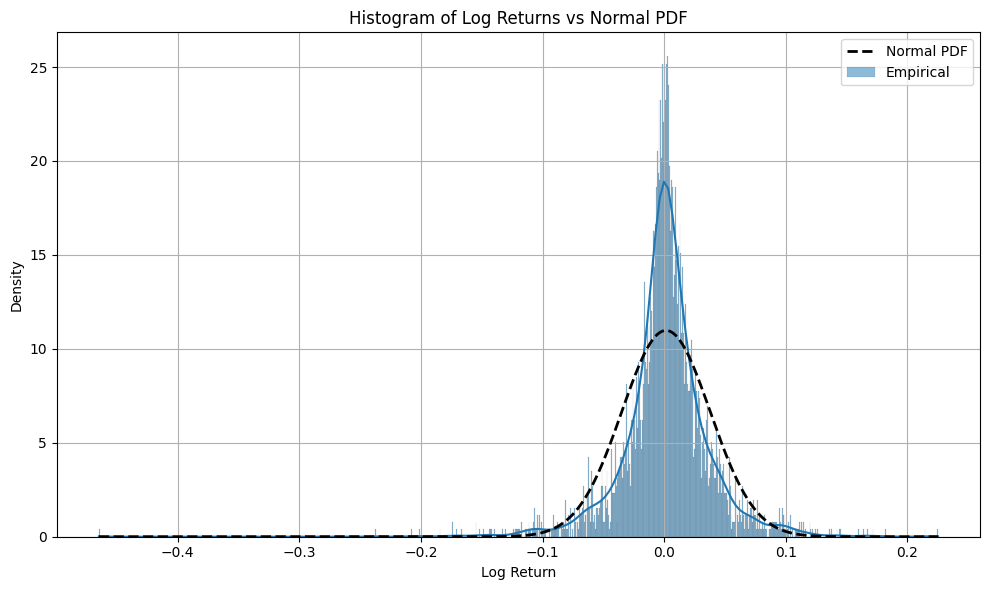

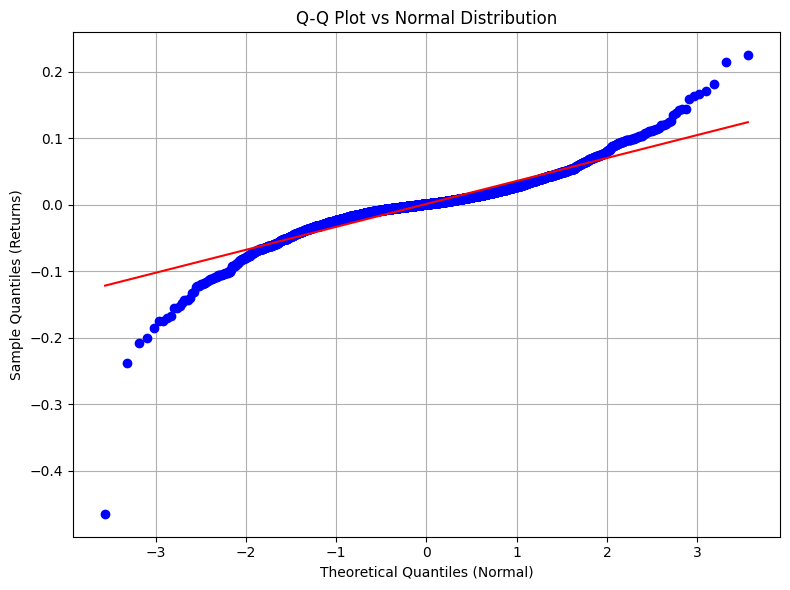

Normality Test p-value: 0.0000
p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import norm

# 히스토그램 + 정규분포 PDF 비교 시각화
plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=1000, kde=True, stat="density", label="Empirical")

# 정규분포 PDF 계산
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, color='black', linestyle='--', linewidth=2, label="Normal PDF")

# 그래프 설정
# plt.xlim(-0.2, -0.1)
plt.title("Histogram of Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q 플롯 (정규분포와 비교)
plt.figure(figsize=(8, 6))
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles (Returns)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 분포 분석
stat, p = normaltest(returns)
print(f"Normality Test p-value: {p:.4f}")
print('p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움')


In [ ]:
print(f"Skewness: {skew(returns):.3f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.3f}")

print('Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음')

Skewness: -0.744
Kurtosis: 11.557
Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음


In [ ]:
# 3. ARCH 효과 테스트
arch_stat, arch_pvalue, _, _ = het_arch(returns)
print(f"ARCH test p-value: {arch_pvalue:.4f}")

# 4. GARCH(1,1) 적합
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())


ARCH test p-value: 0.0000
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2582.65
Distribution:                  Normal   AIC:                          -5157.30
Method:            Maximum Likelihood   BIC:                          -5136.99
                                        No. Observations:                 1185
Date:                Mon, Apr 21 2025   Df Residuals:                     1184
Time:                        04:22:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1810e-03  7.340e

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


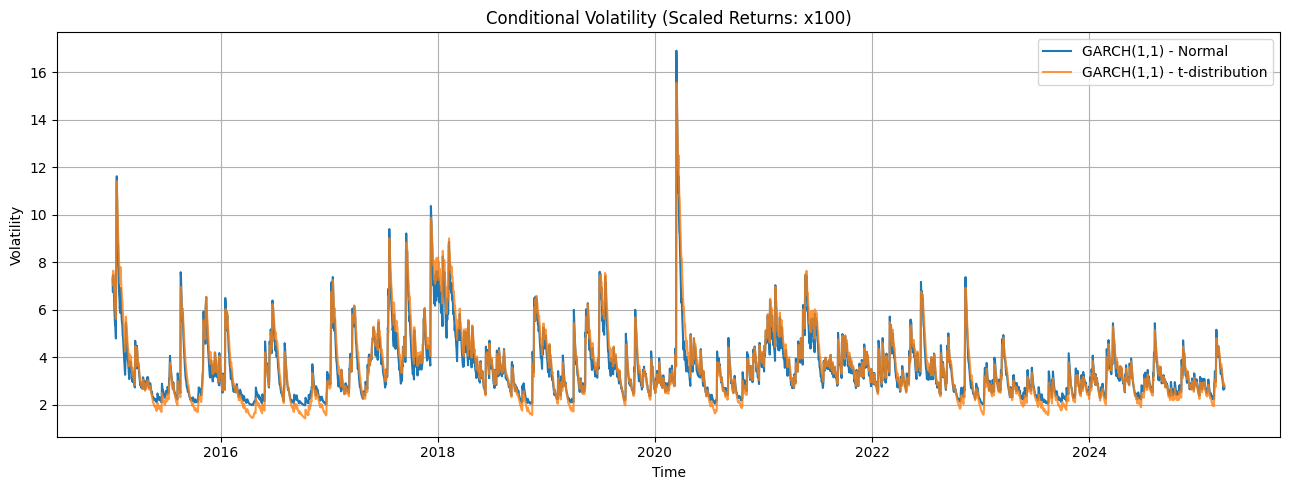

AIC (Normal): 19610.99
AIC (t-dist): 18645.75
Estimated nu (t-dist degrees of freedom): 3.16


In [ ]:
# 📌 GARCH 최적화 안정성을 위해 스케일 조정
returns_scaled = returns * 100

# GARCH(1,1) - Normal
model_normal = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='normal')
res_normal = model_normal.fit(disp='off')

# GARCH(1,1) - t-distribution
model_t = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='t')
res_t = model_t.fit(disp='off')

# 조건부 변동성
vol_normal = res_normal.conditional_volatility
vol_t = res_t.conditional_volatility

# 시각화
plt.figure(figsize=(13, 5))
plt.plot(vol_normal, label='GARCH(1,1) - Normal')
plt.plot(vol_t, label='GARCH(1,1) - t-distribution', alpha=0.8)
plt.title("Conditional Volatility (Scaled Returns: x100)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 성능 지표 출력
print(f"AIC (Normal): {res_normal.aic:.2f}")
print(f"AIC (t-dist): {res_t.aic:.2f}")
print(f"Estimated nu (t-dist degrees of freedom): {res_t.params['nu']:.2f}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skewness: 0.0867
Kurtosis: 22.2356
Normality test p-value: 0.0000


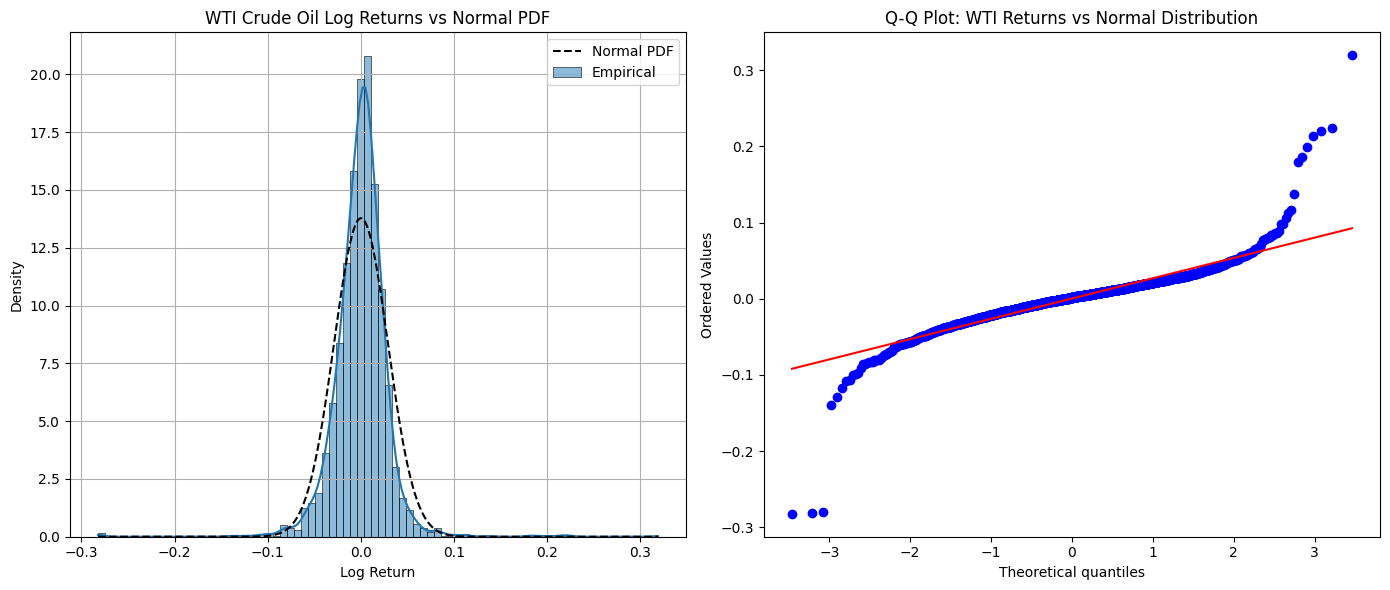

In [ ]:
# 1. WTI 원유 선물 데이터 다운로드 (CL=F)
wti = yf.download("CL=F", start="2015-01-01", end="2025-04-01")
wti.columns = wti.columns.levels[0]
wti["log_ret"] = np.log(wti["Close"] / wti["Close"].shift(1))
returns = wti["log_ret"].dropna()

# 2. 통계량 계산
print(f"Skewness: {skew(returns):.4f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.4f}")
print(f"Normality test p-value: {normaltest(returns).pvalue:.4f}")

# 3. 시각화: 히스토그램 + 정규분포 PDF
plt.figure(figsize=(14, 6))

# 히스토그램 + 정규 PDF
plt.subplot(1, 2, 1)
sns.histplot(returns, bins=80, kde=True, stat="density", label="Empirical")
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, 'k--', label='Normal PDF')
plt.title("WTI Crude Oil Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Q-Q 플롯
plt.subplot(1, 2, 2)
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot: WTI Returns vs Normal Distribution")

plt.tight_layout()
plt.show()


In [2]:
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import norm
from scipy.optimize import brentq

from datetime import datetime

# Black-Scholes 가격 계산 함수
def bs_price(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied Volatility 계산 함수
def implied_vol(price, option_type, S, K, T, r):
    try:
        return brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - price * S, 1e-5, 5)
    except:
        return np.nan

# Deribit에서 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        "currency": currency,
        "kind": kind,
        "expired": str(expired).lower()  # API는 'true' or 'false' string을 요구함
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'error' in data:
        print(f"API Error: {data['error']['message']}")
        return []

    instruments = data.get("result", [])
    return instruments

# 옵션별 IV 계산
def get_iv_for_option(inst_name, strike, expiry_timestamp, mode='mid', otm_only=True, r=0):
    url = f"https://www.deribit.com/api/v2/public/get_order_book?instrument_name={inst_name}"
    response = requests.get(url)
    data = response.json().get('result', {})

    S = data.get('underlying_price')
    K = strike
    bid = data.get('best_bid_price')
    ask = data.get('best_ask_price')
    mid = (bid + ask) / 2 if bid and ask else None

    mark_iv = data.get('mark_iv')
    bid_iv = data.get('bid_iv')
    ask_iv = data.get('ask_iv')

    if mode == 'mid':
      mid = mid
    elif mode == 'bid':
      mid = bid
    elif mode == 'ask':
      mid = ask

    T = (datetime.utcfromtimestamp(expiry_timestamp / 1000) - datetime.utcnow()).total_seconds() / (365 * 24 * 60 * 60)

    if (not mid) or (not expiry_timestamp) or (T <= 0):
        return None

    opt_type = inst_name[-1]
    # OTM : 콜옵션의 행사 가격이 기초 자산의 시장 가격보다 높을 때, 혹은 풋옵션의 행사 가격이 기초 자산의 시장 가격보다 낮을 때
    # ITM 버리기..
    if opt_type == 'C':
        opt_type = 'call'
        if otm_only is True:
            if S > K:
              return None
    elif opt_type == 'P':
        opt_type = 'put'
        if otm_only is True:
          if S < K:
            return None
    else:
        return None

    iv = implied_vol(mid, opt_type, S, K, T, r)

    expiry_date = datetime.utcfromtimestamp(expiry_timestamp / 1000).strftime('%Y-%m-%d')
    return {
        'strike': K,
        'iv': iv,
        'expiry': expiry_date,
        'mark_iv': mark_iv,
        'bid_iv': bid_iv,
        'ask_iv': ask_iv,
        'type' : opt_type
    }

# 만기별 Smile Curve 시각화
def plot_smile_curves(mode, otm_only, cutoff_str):
    options = get_option_instruments()
    iv_data = []

    cutoff_date = datetime.strptime(cutoff_str, '%Y%m%d')
    cutoff_timestamp = int(cutoff_date.timestamp() * 1000)

    for opt in options:
        inst_name = opt['instrument_name']
        strike_opt =  opt['strike']

        expiry_timestamp_opt = opt['expiration_timestamp']
        if (expiry_timestamp_opt > cutoff_timestamp):
          continue

        iv_info = get_iv_for_option(inst_name, strike_opt, expiry_timestamp_opt, mode, otm_only)

        if (iv_info and iv_info['iv'] is not None) and (iv_info['iv'] is not np.nan):
            print(inst_name, iv_info)
            # print(inst_name, iv_info['iv'])
            iv_data.append(iv_info)

    df = pd.DataFrame(iv_data)
    df = df.dropna().sort_values(['expiry', 'strike'])

    plt.figure(figsize=(12, 6))
    for expiry in sorted(df['expiry'].unique()):
        subset = df[df['expiry'] == expiry]
        plt.plot(subset['strike'], subset['iv'], marker='o', label=expiry)

    plt.title("BTC Implied Volatility Smile Curves by Expiry by " + mode)
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend(title="Expiry")
    plt.tight_layout()
    plt.show()

    df['mode'] = mode
    return df

def get_btc_futures_last_price(instrument_name="BTC-PERPETUAL"):
    """
    Deribit에서 지정한 비트코인 선물 종목의 현재가(last price)를 반환합니다.

    Parameters:
    - instrument_name: 예) 'BTC-PERPETUAL', 'BTC-27JUN25'

    Returns:
    - 현재가 (float), 실패 시 None
    """
    url = "https://www.deribit.com/api/v2/public/ticker"
    params = {"instrument_name": instrument_name}

    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data["result"]["last_price"]
    except Exception as e:
        print(f"에러 발생: {e}")
        return None

BTC-23APR25-76000-P {'strike': 76000.0, 'iv': 1.2134508831449802, 'expiry': '2025-04-23', 'mark_iv': 87.93, 'bid_iv': 0.0, 'ask_iv': 121.34, 'type': 'put'}
BTC-23APR25-78000-P {'strike': 78000.0, 'iv': 1.0275432262337232, 'expiry': '2025-04-23', 'mark_iv': 87.93, 'bid_iv': 0.0, 'ask_iv': 102.75, 'type': 'put'}
BTC-23APR25-80000-P {'strike': 80000.0, 'iv': 0.9211693339744633, 'expiry': '2025-04-23', 'mark_iv': 87.93, 'bid_iv': 84.33, 'ask_iv': 92.12, 'type': 'put'}
BTC-23APR25-81000-P {'strike': 81000.0, 'iv': 0.8226794036840697, 'expiry': '2025-04-23', 'mark_iv': 78.53, 'bid_iv': 75.16, 'ask_iv': 82.27, 'type': 'put'}
BTC-23APR25-82000-P {'strike': 82000.0, 'iv': 0.7241058039270615, 'expiry': '2025-04-23', 'mark_iv': 69.04, 'bid_iv': 65.99, 'ask_iv': 72.41, 'type': 'put'}
BTC-23APR25-83000-P {'strike': 83000.0, 'iv': 0.6654222414766632, 'expiry': '2025-04-23', 'mark_iv': 62.04, 'bid_iv': 56.79, 'ask_iv': 66.54, 'type': 'put'}
BTC-23APR25-84000-P {'strike': 84000.0, 'iv': 0.589575233679

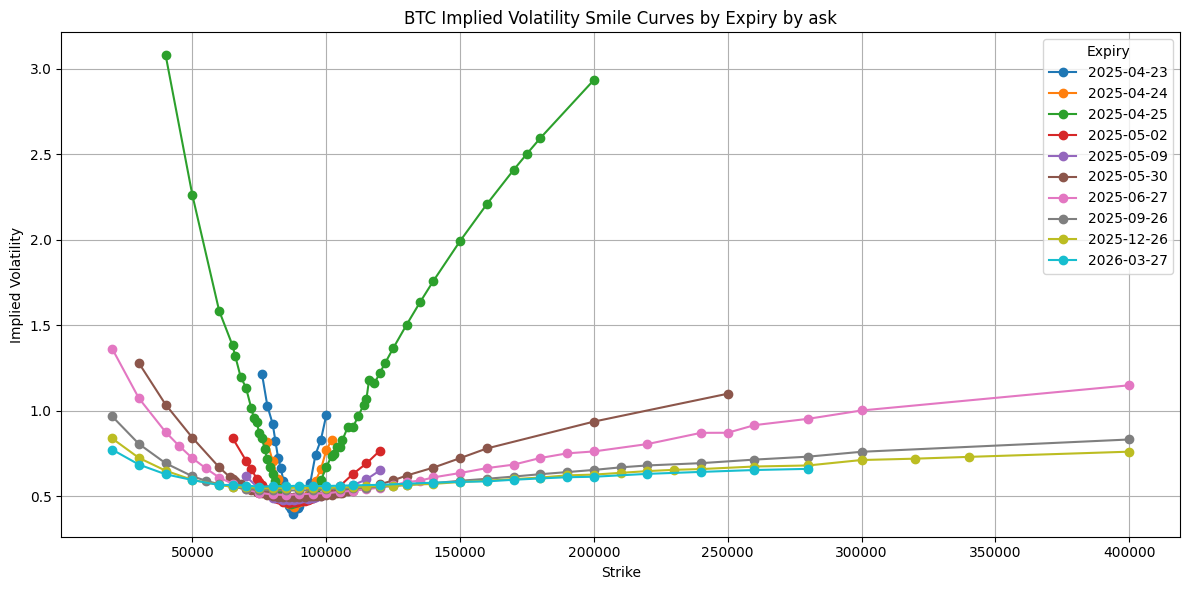

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,76000.0,1.213451,2025-04-23,87.93,0.00,121.34,put,ask
1,78000.0,1.027543,2025-04-23,87.93,0.00,102.75,put,ask
2,80000.0,0.921169,2025-04-23,87.93,84.33,92.12,put,ask
3,81000.0,0.822679,2025-04-23,78.53,75.16,82.27,put,ask
4,82000.0,0.724106,2025-04-23,69.04,65.99,72.41,put,ask
...,...,...,...,...,...,...,...,...
324,200000.0,0.612798,2026-03-27,60.62,60.00,61.28,call,ask
325,220000.0,0.629702,2026-03-27,62.10,61.27,62.97,call,ask
326,240000.0,0.641167,2026-03-27,63.27,62.45,64.12,call,ask
327,260000.0,0.652164,2026-03-27,64.49,63.65,65.22,call,ask


In [3]:
# price * S // otm_only
df_ask = plot_smile_curves(mode='ask', otm_only=True, cutoff_str='20261231')
df_ask

BTC-23APR25-80000-P {'strike': 80000.0, 'iv': 0.8396926061928883, 'expiry': '2025-04-23', 'mark_iv': 87.99, 'bid_iv': 83.98, 'ask_iv': 91.74, 'type': 'put'}
BTC-23APR25-81000-P {'strike': 81000.0, 'iv': 0.7476848104218315, 'expiry': '2025-04-23', 'mark_iv': 78.81, 'bid_iv': 74.77, 'ask_iv': 81.86, 'type': 'put'}
BTC-23APR25-82000-P {'strike': 82000.0, 'iv': 0.6556922374872014, 'expiry': '2025-04-23', 'mark_iv': 69.29, 'bid_iv': 65.57, 'ask_iv': 71.96, 'type': 'put'}
BTC-23APR25-83000-P {'strike': 83000.0, 'iv': 0.5635660481330124, 'expiry': '2025-04-23', 'mark_iv': 62.16, 'bid_iv': 56.36, 'ask_iv': 66.06, 'type': 'put'}
BTC-23APR25-84000-P {'strike': 84000.0, 'iv': 0.5203591780587998, 'expiry': '2025-04-23', 'mark_iv': 54.31, 'bid_iv': 52.04, 'ask_iv': 58.42, 'type': 'put'}
BTC-23APR25-85000-P {'strike': 85000.0, 'iv': 0.44910168120145044, 'expiry': '2025-04-23', 'mark_iv': 47.73, 'bid_iv': 44.91, 'ask_iv': 49.49, 'type': 'put'}
BTC-23APR25-86000-P {'strike': 86000.0, 'iv': 0.393348188

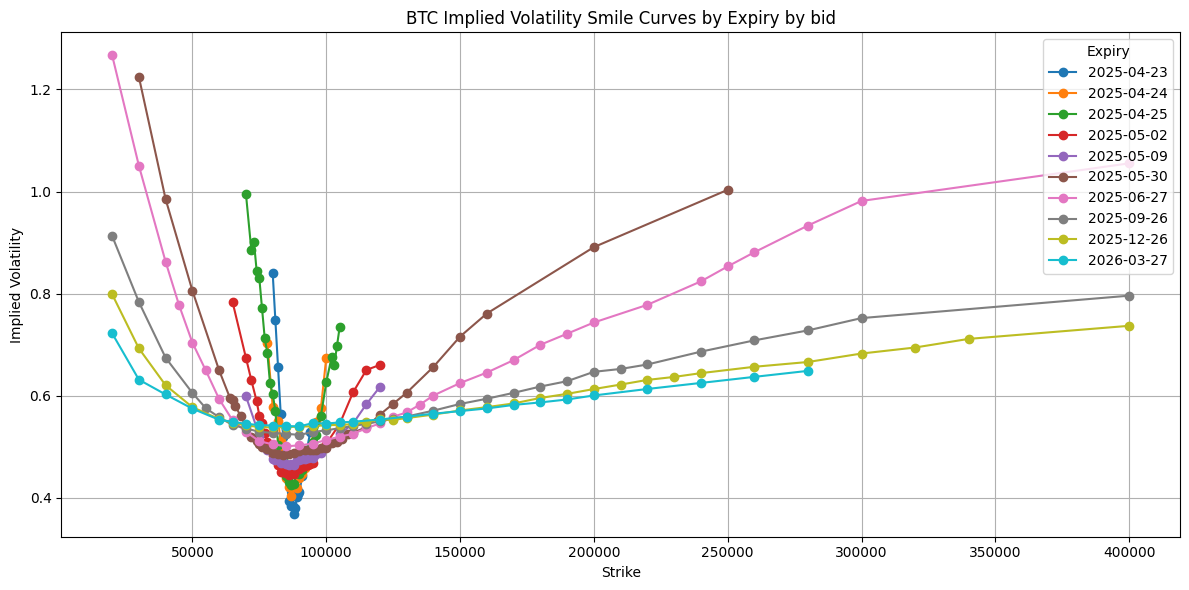

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,80000.0,0.839693,2025-04-23,87.99,83.98,91.74,put,bid
1,81000.0,0.747685,2025-04-23,78.81,74.77,81.86,put,bid
2,82000.0,0.655692,2025-04-23,69.29,65.57,71.96,put,bid
3,83000.0,0.563566,2025-04-23,62.16,56.36,66.06,put,bid
4,84000.0,0.520359,2025-04-23,54.31,52.04,58.42,put,bid
...,...,...,...,...,...,...,...,...
292,200000.0,0.600765,2026-03-27,60.65,60.08,61.36,call,bid
293,220000.0,0.613460,2026-03-27,62.13,61.35,63.05,call,bid
294,240000.0,0.625287,2026-03-27,63.29,62.53,64.19,call,bid
295,260000.0,0.637197,2026-03-27,64.52,63.72,65.29,call,bid


In [4]:
# price * S // otm_only
df_bid = plot_smile_curves(mode='bid', otm_only=True, cutoff_str='20261231')
df_bid

BTC-23APR25-80000-P {'strike': 80000.0, 'iv': 0.8688391216658015, 'expiry': '2025-04-23', 'mark_iv': 87.47, 'bid_iv': 82.59, 'ask_iv': 90.25, 'type': 'put'}
BTC-23APR25-81000-P {'strike': 81000.0, 'iv': 0.7729498755363219, 'expiry': '2025-04-23', 'mark_iv': 78.23, 'bid_iv': 73.39, 'ask_iv': 80.37, 'type': 'put'}
BTC-23APR25-82000-P {'strike': 82000.0, 'iv': 0.6767902782362523, 'expiry': '2025-04-23', 'mark_iv': 68.69, 'bid_iv': 64.16, 'ask_iv': 70.45, 'type': 'put'}
BTC-23APR25-83000-P {'strike': 83000.0, 'iv': 0.6048181239915046, 'expiry': '2025-04-23', 'mark_iv': 61.48, 'bid_iv': 54.9, 'ask_iv': 64.41, 'type': 'put'}
BTC-23APR25-84000-P {'strike': 84000.0, 'iv': 0.5226656706117414, 'expiry': '2025-04-23', 'mark_iv': 53.57, 'bid_iv': 50.45, 'ask_iv': 53.89, 'type': 'put'}
BTC-23APR25-85000-P {'strike': 85000.0, 'iv': 0.45548134356414055, 'expiry': '2025-04-23', 'mark_iv': 47.09, 'bid_iv': 43.17, 'ask_iv': 47.63, 'type': 'put'}
BTC-23APR25-86000-P {'strike': 86000.0, 'iv': 0.4188521267

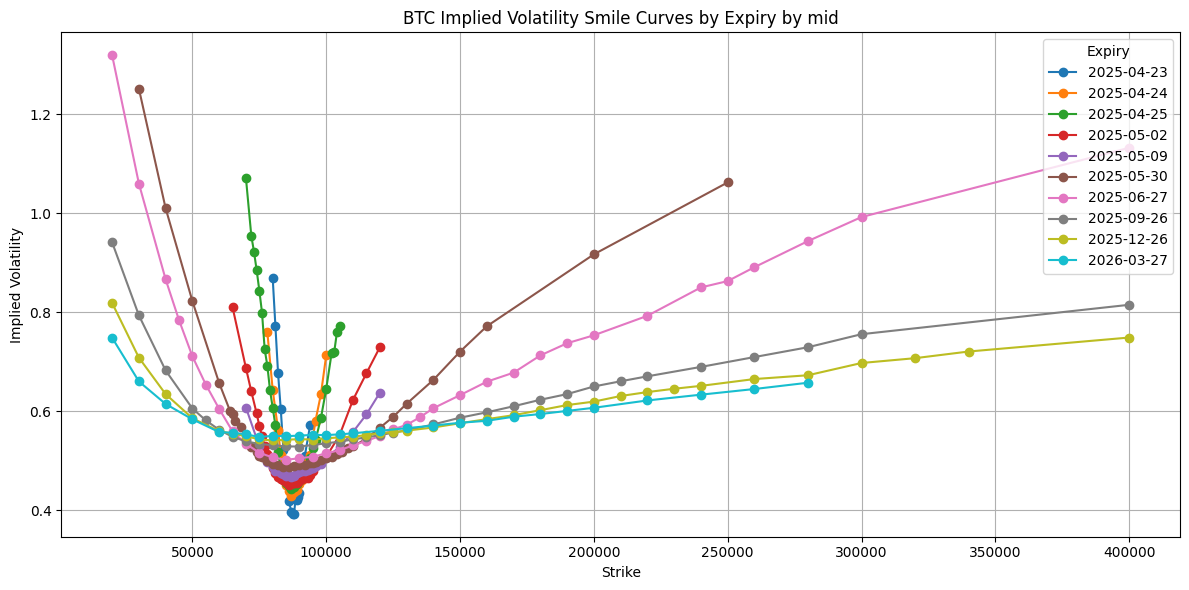

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,80000.0,0.868839,2025-04-23,87.47,82.59,90.25,put,mid
1,81000.0,0.772950,2025-04-23,78.23,73.39,80.37,put,mid
2,82000.0,0.676790,2025-04-23,68.69,64.16,70.45,put,mid
3,83000.0,0.604818,2025-04-23,61.48,54.90,64.41,put,mid
4,84000.0,0.522666,2025-04-23,53.57,50.45,53.89,put,mid
...,...,...,...,...,...,...,...,...
292,200000.0,0.607163,2026-03-27,60.67,60.07,61.35,call,mid
293,220000.0,0.622000,2026-03-27,62.15,61.34,63.04,call,mid
294,240000.0,0.633660,2026-03-27,63.32,62.52,64.19,call,mid
295,260000.0,0.645098,2026-03-27,64.54,63.71,65.28,call,mid


In [5]:
df_mid = plot_smile_curves(mode='mid', otm_only=True, cutoff_str='20261231')
df_mid

In [126]:
df_ask_ = df_ask[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_ask'})
df_bid_ = df_bid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_bid'})

df_merged = pd.merge(df_bid_, df_ask_, on=["strike", "expiry"], how="inner")[['strike', 'expiry', 'iv_bid', 'iv_ask']]

# melt로 long form 변환|
df_long = pd.melt(df_merged, id_vars=["strike", "expiry"], value_vars=["iv_bid", "iv_ask"], var_name="iv_type", value_name="implied_volatility")

# Plotly로 인터랙티브 그래프 그리기
fig = px.line(df_long, x="strike", y="implied_volatility", color="expiry", line_dash="iv_type", markers=True,
    title="Interactive Implied Volatility Curve by Expiry and IV Type",
    labels={"strike": "Strike", "implied_volatility": "Implied Volatility"})

fig.update_layout(legend_title_text="Expiry / IV Type", hovermode="x unified")
fig.show()

In [83]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage2(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

In [89]:
find_butterfly_arbitrage2(df_merged, threshold=0.025)

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [90]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

# 버터플라이 시각화 함수
def plot_butterfly_opportunities(df_butterfly):
    for _, row in df_butterfly.iterrows():
        strikes = [row['K1'], row['K2'], row['K3']]
        ivs = [row['iv_side_avg'], row['iv_center'], row['iv_side_avg']]
        plt.plot(strikes, ivs, marker='o', label=f"Expiry: {row['expiry']}")

    plt.title("Butterfly Arbitrage Opportunities")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

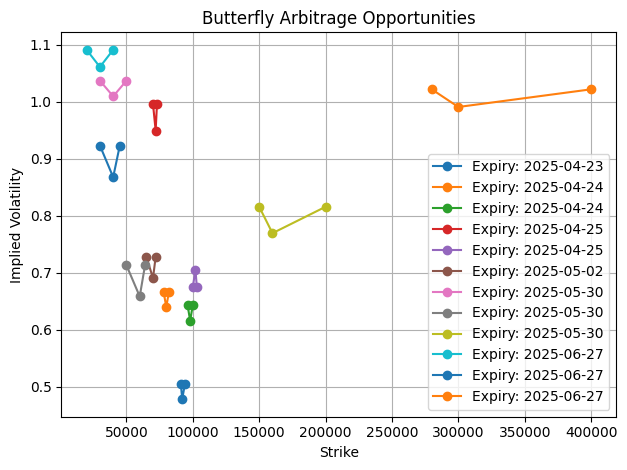

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [97]:
df_butterfly = find_butterfly_arbitrage(df_merged, threshold=0.025)
plot_butterfly_opportunities(df_butterfly)
df_butterfly

In [119]:
# 캘린더 차익 탐색 함수
def find_calendar_arbitrage(df, threshold=0.03):
    grouped = df.groupby('strike')
    ideas = []

    for strike, group in grouped:
        if len(group) < 2:
            continue
        group = group.sort_values('expiry')
        for i in range(len(group)-1):
            near = group.iloc[i]
            far = group.iloc[i+1]

            iv_near = (near['iv_bid'] + near['iv_ask']) / 2
            iv_far = (far['iv_bid'] + far['iv_ask']) / 2

            if abs(iv_far - iv_near) > threshold:
                ideas.append({
                    "type": "Calendar Spread",
                    "strike": strike,
                    "near_expiry": near['expiry'],
                    "far_expiry": far['expiry'],
                    "iv_near": iv_near,
                    "iv_far": iv_far,
                    "direction": "Long Calendar" if iv_far > iv_near else "Short Calendar"
                })
    return pd.DataFrame(ideas)

def find_calendar_butterfly(df, threshold=0.03):
  ideas = []
  grouped = df.groupby('strike')

  for strike, group in grouped:
      if len(group) < 3:
          continue

      group = group.sort_values('expiry').reset_index(drop=True)

      for i in range(len(group)-2):
          T1 = group.iloc[i]
          T2 = group.iloc[i+1]
          T3 = group.iloc[i+2]

          iv1 = (T1['iv_bid'] + T1['iv_ask']) / 2
          iv2 = (T2['iv_bid'] + T2['iv_ask']) / 2
          iv3 = (T3['iv_bid'] + T3['iv_ask']) / 2

          side_avg = (iv1 + iv3) / 2
          diff = iv2 - side_avg

          if abs(diff) > threshold:
              direction = "Short Calendar Butterfly" if diff > 0 else "Long Calendar Butterfly"
              ideas.append({
                  'type': 'Calendar Butterfly',
                  'direction': direction,
                  'strike': strike,
                  'T1': T1['expiry'],
                  'T2': T2['expiry'],
                  'T3': T3['expiry'],
                  'iv_T1': iv1,
                  'iv_T2': iv2,
                  'iv_T3': iv3,
                  'center_deviation' : diff
              })

  return pd.DataFrame(ideas)

# 캘린더 차익 시각화 함수
def plot_calendar_opportunities(df_calendar):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar.iterrows():
        x = pd.to_datetime([row['near_expiry'], row['far_expiry']])
        y = [row['iv_near'], row['iv_far']]
        plt.plot(x, y, marker='o', label=f"Strike {row['strike']} ({row['direction']})")

    plt.title("Calendar Arbitrage Across Expiries")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 캘린더 버터플라이 시각화 함수
def plot_calendar_butterfly_opportunities(df_calendar_butterfly):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar_butterfly.iterrows():
        expiries = pd.to_datetime([row['T1'], row['T2'], row['T3']])
        ivs = [row['iv_T1'], row['iv_T2'], row['iv_T3']]
        plt.plot(expiries, ivs, marker='o', label=f"Strike: {row['strike']} ({row['direction']})")

    plt.title("Calendar Butterfly Opportunities")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [124]:
# df_cal = find_calendar_arbitrage(df_merged, threshold=0.25)
# plot_calendar_opportunities(df_cal)
# df_cal

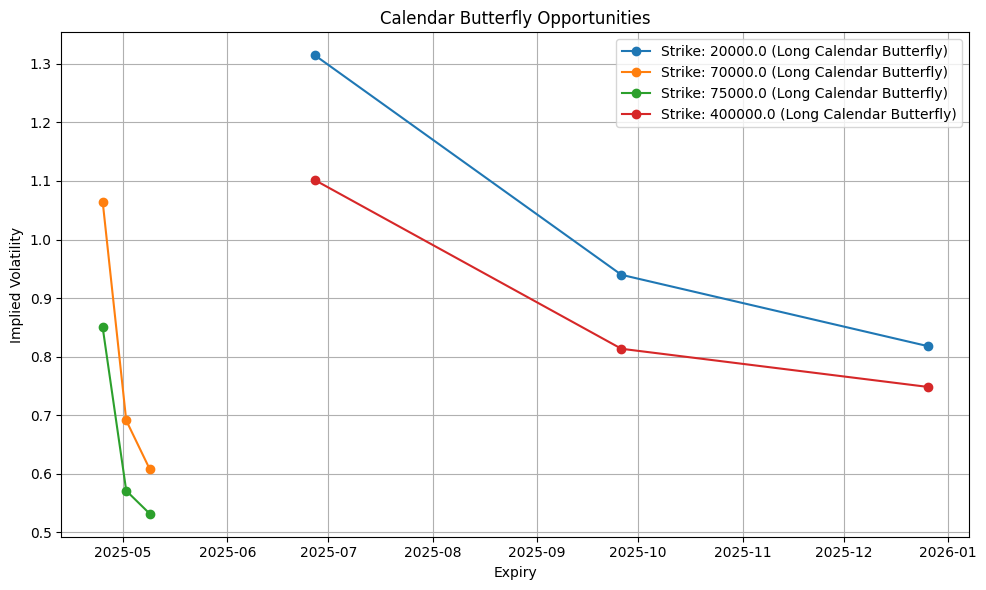

,type,direction,strike,T1,T2,T3,iv_T1,iv_T2,iv_T3,center_deviation
0,Calendar Butterfly,Long Calendar Butterfly,20000.0,2025-06-27,2025-09-26,2025-12-26,1.314657,0.939769,0.817928,-0.126523
1,Calendar Butterfly,Long Calendar Butterfly,70000.0,2025-04-25,2025-05-02,2025-05-09,1.064777,0.691007,0.607577,-0.145170
2,Calendar Butterfly,Long Calendar Butterfly,75000.0,2025-04-25,2025-05-02,2025-05-09,0.849994,0.571010,0.531657,-0.119815
3,Calendar Butterfly,Long Calendar Butterfly,400000.0,2025-06-27,2025-09-26,2025-12-26,1.101506,0.813461,0.748298,-0.111441


In [123]:
df_calendar_butterfly = find_calendar_butterfly(df_merged, threshold=0.11)
plot_calendar_butterfly_opportunities(df_calendar_butterfly)
df_calendar_butterfly

In [ ]:
get_iv_for_option(inst_name)

{'timestamp': 1745227517223, 'state': 'open', 'stats': {'high': None, 'low': None, 'price_change': None, 'volume': 0.0, 'volume_usd': 0.0}, 'greeks': {'delta': 0.99991, 'gamma': 0.0, 'vega': 0.01606, 'theta': -0.5964, 'rho': 1.95908}, 'change_id': 97992839864, 'index_price': 87448.23, 'instrument_name': 'BTC-22APR25-76000-C', 'bids': [[0.0995, 10.3]], 'asks': [[0.1605, 10.3]], 'last_price': None, 'settlement_price': 0.13092624, 'min_price': 0.0995, 'max_price': 0.1605, 'open_interest': 0.0, 'mark_price': 0.131, 'best_ask_price': 0.1605, 'best_bid_price': 0.0995, 'interest_rate': 0.0, 'mark_iv': 74.25, 'bid_iv': 0.0, 'ask_iv': 414.29, 'underlying_price': 87456.8408, 'underlying_index': 'SYN.BTC-22APR25', 'estimated_delivery_price': 87448.23, 'best_ask_amount': 10.3, 'best_bid_amount': 10.3}


In [ ]:
get_option_instruments()[0]

{'price_index': 'btc_usd',
 'rfq': False,
 'kind': 'option',
 'instrument_name': 'BTC-22APR25-76000-C',
 'maker_commission': 0.0003,
 'taker_commission': 0.0003,
 'instrument_type': 'reversed',
 'expiration_timestamp': 1745308800000,
 'creation_timestamp': 1745049608000,
 'is_active': True,
 'tick_size': 0.0001,
 'contract_size': 1.0,
 'strike': 76000.0,
 'base_currency': 'BTC',
 'instrument_id': 455660,
 'settlement_period': 'day',
 'min_trade_amount': 0.1,
 'option_type': 'call',
 'block_trade_commission': 0.0003,
 'block_trade_min_trade_amount': 25,
 'block_trade_tick_size': 0.0001,
 'settlement_currency': 'BTC',
 'counter_currency': 'USD',
 'quote_currency': 'BTC',
 'tick_size_steps': [{'tick_size': 0.0005, 'above_price': 0.005}]}